In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge

In [242]:
%run functions.py

In [243]:
df_train_clean = pd.read_csv('../data/train_clean.csv')
df_test_clean = pd.read_csv('../data/test_clean.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [244]:
features = ['lot_area', 'condition_1', 'central_air',
            '1st_flr_sf', 'gr_liv_area', 'full_bath', 'bedroom_abvgr',
            'kitchen_qual', 'fireplaces', 'garage_cars',
            'garage_area', 'garage_cond', 'paved_drive', 'yr_sold',
            'age', 'quality', 'remod', 'bsmt_rating', 'bsmt_sf']

In [245]:
features = ['gr_liv_area', '1st_flr_sf', 'bsmt_sf', 'quality', 'age', 'remod']

In [246]:
features = df_train_clean.columns.drop('saleprice')

In [247]:
features = df_train_clean.columns.drop(['saleprice', 'yr_sold', 'year_built'])
features

Index(['ms_zoning', 'lot_area', 'condition_1', 'overall_qual', 'overall_cond',
       'year_remod/add', 'exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond',
       'bsmt_unf_sf', 'total_bsmt_sf', 'central_air', '1st_flr_sf',
       'gr_liv_area', 'full_bath', 'bedroom_abvgr', 'kitchen_abvgr',
       'kitchen_qual', 'fireplaces', 'garage_cars', 'garage_area',
       'garage_qual', 'garage_cond', 'paved_drive', 'age', 'quality', 'remod',
       'bsmt_rating', 'bsmt_sf'],
      dtype='object')

## Natural Log Model

In [248]:
X = df_train_clean[features].copy()

In [249]:
y = df_train_clean['saleprice'].copy()
y = y.map(np.log)

In [250]:
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=42)

Create a new linear regression model and fit it over the train data.  
Then, calculate the Train score, Test score, and Baseline score.

In [251]:
model_log = LinearRegression()
model_log.fit(X_train, y_train)
calc_scores(model_log, X_train, y_train, X_test, y_test)

Train score  0.852602848601379
Test score   0.8853802725180739
Baseline     0.8051272131677297


Predict the sale price for the test data.

In [252]:
y_pred_log = model_log.predict(X_test)
resids_log = y_test - y_pred_log

Reverse the predictions for test and predicted sale price from natural log to price units.

In [253]:
y_pred = np.exp(y_pred_log)
y_test = np.exp(y_test)
y_train = np.exp(y_train)

Calculate metrics for true values vs. predicted values of the sales price.

In [254]:
calc_metrics(y_test, y_pred)

RMSE 27644.381221118038
MSE  764211813.0985036
R2   0.8867009082023214
MAE  18349.31952736196


#### For 1 unit increase (square foot) in gr_liv_area, holding all other variables constant, we can expect the average price of a home to increase by 0.185%.
#### For 1 unit increase (year) in age, holding all other values constant, we can expect the average price of a home to drop by 2.24%.

In [255]:
model_log.intercept_

22.641723945109096

In [256]:
coef = zip(X_test.columns, model_log.coef_)
df_coef = pd.DataFrame(coef, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)
df_coef

,Feature,Coefficient
8,bsmt_qual,0.154431
9,bsmt_cond,0.150123
3,overall_qual,0.104038
6,exter_qual,0.085498
20,garage_cars,0.083772
12,central_air,0.070698
22,garage_qual,0.065544
4,overall_cond,0.062740
7,exter_cond,0.055926
18,kitchen_qual,0.051320


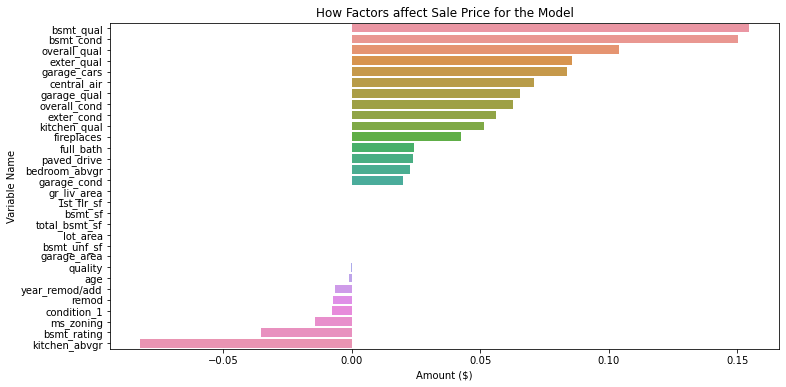

In [257]:
plt.figure(figsize=(12,6))
plt.title('How Factors affect Sale Price for the Model')
ax = sns.barplot(x='Coefficient', y='Feature', data=df_coef)
ax.set(xlabel='Amount ($)', ylabel='Variable Name');

## Lasso Model.

In [258]:
X = df_train_clean[features].copy()
y = df_train_clean['saleprice'].copy()

In [259]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)

In [260]:
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=42)

In [261]:
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

In [262]:
lasso_alphas = np.logspace(-3, 0, 100)
lasso_cv_model = LassoCV(alphas=lasso_alphas, cv=5, max_iter=100_000)
lasso_cv_model.fit(Z_train, y_train);

In [263]:
calc_scores(lasso_cv_model, Z_train, y_train, Z_test, y_test)

Train score  0.8182018919057666
Test score   0.8417851928397275
Baseline     0.7787096531885673


In [264]:
y_pred = lasso_cv_model.predict(Z_test)

In [265]:
calc_metrics(y_test, y_pred)

RMSE 30701.474184258648
MSE  942580517.0867003
R2   0.8417851928397275
MAE  20856.409792720337


#### For 1 unit increase (standard deviation) in gr_liv_area, holding all other variables constant, we can expect the average price of a home to increase by $28,835.  

#### For 1 unit increase (standard deviation) in age, holding all other variables constant, we can expect the average price of a home to decrease by $22,027.

In [266]:
lasso_cv_model.intercept_

189278.36666666664

In [267]:
coef = zip(X_test.columns, lasso_cv_model.coef_)
df_coef = pd.DataFrame(coef, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)
df_coef

,Feature,Coefficient
3,overall_qual,19620.538224
28,bsmt_rating,16966.015122
14,gr_liv_area,16341.587735
6,exter_qual,10620.768423
18,kitchen_qual,7941.942673
29,bsmt_sf,7663.764418
20,garage_cars,6957.832824
21,garage_area,5044.702459
13,1st_flr_sf,4656.512273
19,fireplaces,4245.090901


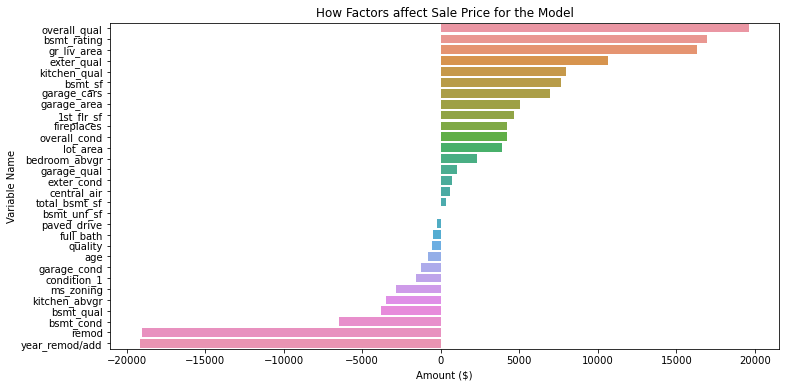

In [268]:
plt.figure(figsize=(12,6))
plt.title('How Factors affect Sale Price for the Model')
ax = sns.barplot(x='Coefficient', y='Feature', data=df_coef)
ax.set(xlabel='Amount ($)', ylabel='Variable Name');

## Ridge Model

In [269]:
X = df_train_clean[features].copy()
y = df_train_clean['saleprice'].copy()

In [270]:
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=42)

In [271]:
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

In [272]:
ridge_model = Ridge(alpha=100)
ridge_model.fit(Z_train, y_train)

Ridge(alpha=100)

In [273]:
calc_scores(ridge_model, Z_train, y_train, Z_test, y_test)

Train score  0.8129264030117118
Test score   0.8477534433649552
Baseline     0.7774600874625521


In [274]:
y_pred = ridge_model.predict(Z_test)

In [275]:
calc_metrics(y_test, y_pred)

RMSE 32045.52555555181
MSE  1026915708.131524
R2   0.8477534433649552
MAE  21164.551613425763


#### For 1 unit increase (standard deviation) in gr_liv_area, holding all other variables constant, we can expect the average price of a home to increase by $18,422.  

#### For 1 unit increase (standard deviation) in age, holding all other variables constant, we can expect the average price of a home to decrease by $8,638.

In [276]:
ridge_model.intercept_

188184.5304964539

In [277]:
coef = zip(X_test.columns, ridge_model.coef_)
df_coef = pd.DataFrame(coef, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)
df_coef

,Feature,Coefficient
3,overall_qual,15200.237419
14,gr_liv_area,14863.418807
18,kitchen_qual,8340.531051
20,garage_cars,7655.894424
8,bsmt_qual,6243.159288
6,exter_qual,6228.777555
26,quality,5744.489291
28,bsmt_rating,4940.048713
1,lot_area,4720.895210
19,fireplaces,4573.680132


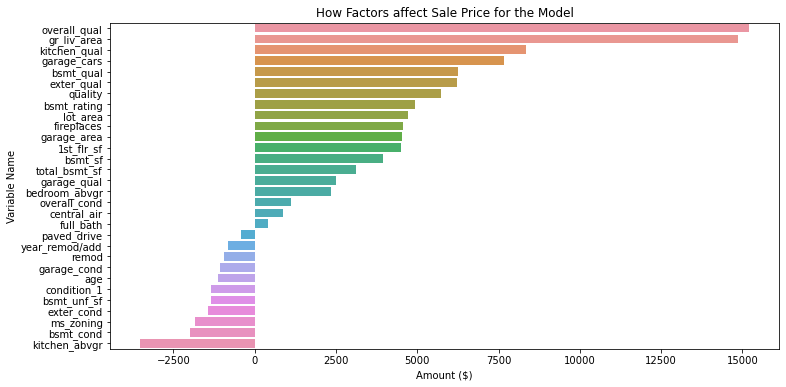

In [278]:
plt.figure(figsize=(12,6))
plt.title('How Factors affect Sale Price for the Model')
ax = sns.barplot(x='Coefficient', y='Feature', data=df_coef)
ax.set(xlabel='Amount ($)', ylabel='Variable Name');